In [2]:
from fastai.vision import *

In [3]:
imgs = Path('/home/jupyter/state-farm-distracted-driver-detection/imgs')

In [3]:
data = imgs/'train'

In [4]:
np.random.seed(42)

In [5]:
dbunch = ImageDataBunch.from_folder(data, train=".", valid_pct=0.2,
                                   ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [6]:
dbunch.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

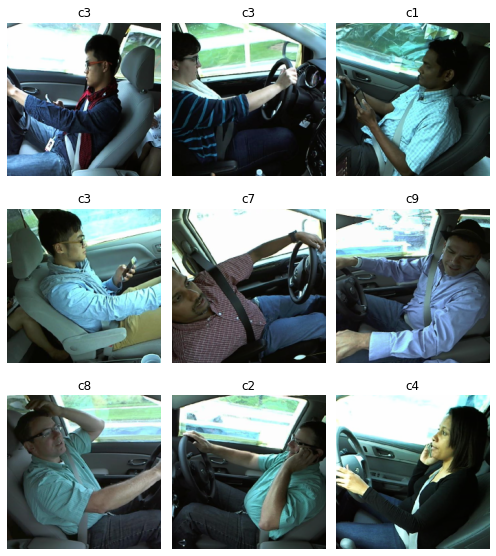

In [8]:
dbunch.show_batch(rows=3, figsize=(7,8))

In [10]:
model = models.resnet34
figname = "resnet-34"

In [41]:
model = models.resnet50
figname = "resnet-50"

In [33]:
from sklearn.metrics import log_loss

In [36]:
learn = cnn_learner(dbunch, model, metrics=error_rate)

In [37]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.859476,0.306086,0.092774,02:49
1,0.417842,0.150746,0.041258,02:47
2,0.266400,0.139776,0.041035,02:48
3,0.197305,0.094651,0.025201,02:48
4,0.134837,0.064524,0.014719,02:48
5,0.097779,0.040086,0.009144,02:49
6,0.068650,0.037499,0.009590,02:50
7,0.053459,0.034632,0.007806,02:50
8,0.041096,0.028661,0.006467,02:48
9,0.038766,0.028436,0.006913,02:48


In [38]:
learn.save(figname + '-stage-1')

In [55]:
learn.load(figname + '-stage-1');

In [47]:
learn.unfreeze()

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


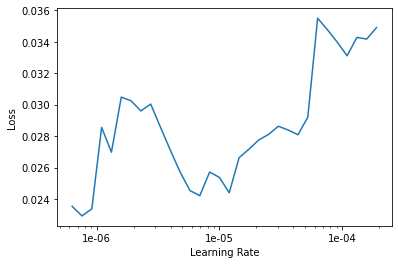

In [42]:
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(5, max_lr=slice(4e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.039830,0.029316,0.007136,02:51
1,0.041961,0.018353,0.004014,02:52
2,0.021965,0.020357,0.004683,02:53
3,0.018319,0.019524,0.004237,02:52
4,0.010149,0.017425,0.004237,02:51


In [49]:
learn.save(figname + '2-stage-2')

In [ ]:
learn.load(figname + '-stage-2')

In [56]:
learn.export()

Let's try to do this with a custom ImageList.

In [14]:
src = (ImageList.from_folder(imgs/'train')
       .split_by_rand_pct(0.2)
       .label_from_folder()
       .add_test_folder(imgs/'test'))

Use size=128 for starters.

In [15]:
data = (src.transform(get_transforms(), size=128)
        .databunch().
        normalize(imagenet_stats))

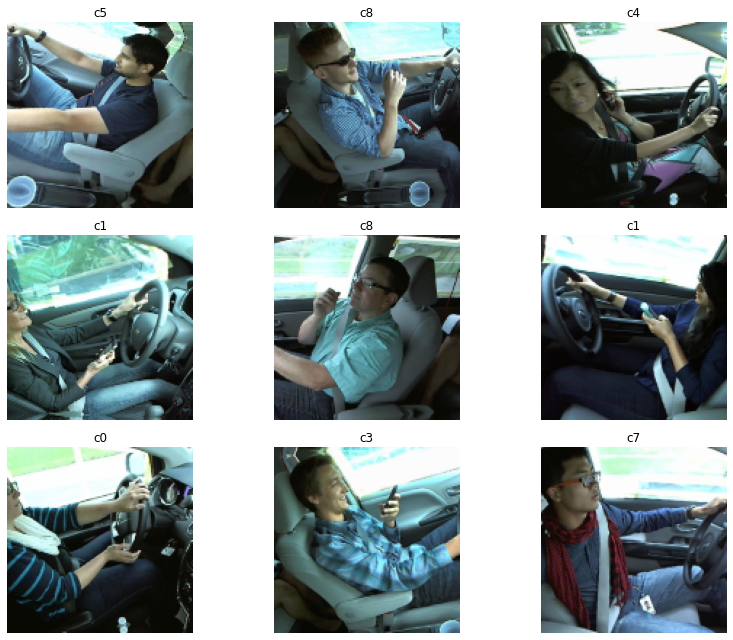

In [16]:
data.show_batch(rows=3, figsize=(12,9))

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Find the correct lr.

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


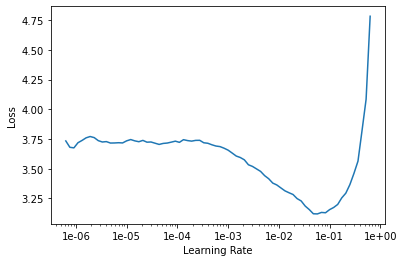

In [18]:
learn.lr_find()
learn.recorder.plot();

In [19]:
lr = 1e-2

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.276167,0.620811,0.206066,01:31
1,0.613518,0.282872,0.096789,01:09
2,0.376210,0.138489,0.040366,01:10
3,0.269903,0.101104,0.029438,01:12
4,0.197924,0.090324,0.024978,01:11


Save and fine tune the whole model...

In [21]:
learn.save('resnet34-custom-stage-1')

In [22]:
learn.load('resnet34-custom-stage-1');

In [23]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


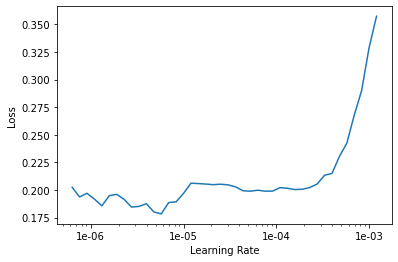

In [24]:
learn.lr_find()
learn.recorder.plot();

In [25]:
learn.fit_one_cycle(5, slice(3e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.187812,0.092428,0.025201,01:10
1,0.133030,0.062686,0.015611,01:10
2,0.068652,0.029832,0.008698,01:10
3,0.031855,0.022286,0.005352,01:10
4,0.023468,0.021089,0.005352,01:10


In [26]:
learn.save('resnet34-custom-stage-2')

Now go on and try with a different size.

In [27]:
data = (src.transform(get_transforms(), size=256).databunch().normalize(imagenet_stats))

In [28]:
learn.data = data

And repeat the process.

In [29]:
learn.freeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


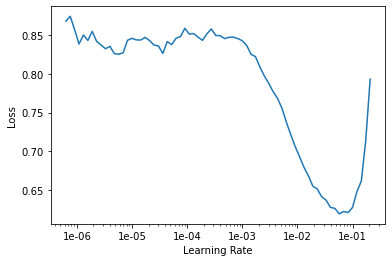

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
lr = 1e-2

In [32]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.178091,0.060726,0.016726,01:23
1,0.119280,0.058893,0.015388,01:24
2,0.088735,0.043442,0.011597,01:24
3,0.039698,0.029505,0.007583,01:23
4,0.043888,0.027459,0.006690,01:24


In [33]:
learn.save('resnet34-custom-stage-1-256')

In [35]:
learn.load('resnet34-custom-stage-1-256');

In [36]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


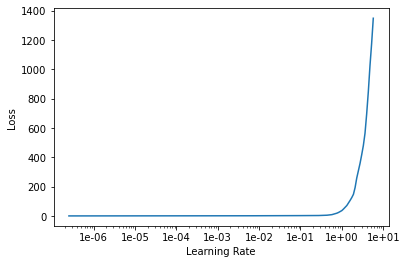

In [43]:
learn.lr_find(stop_div=False, num_it=200)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('resnet34-custom-stage-2-256')

Aaaaaaaand get predictions.

In [57]:
learn = load_learner(data, test=ImageList.from_folder(imgs/'test'))

In [106]:
learn.load('resnet34-custom-stage-2');

In [38]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [39]:
submission = pd.DataFrame({'img': os.listdir(imgs/'test'),
                          'c0': preds[:,0],
                          'c1': preds[:,1],
                          'c2': preds[:,2],
                          'c3': preds[:,3],
                          'c4': preds[:,4],
                          'c5': preds[:,5],
                          'c6': preds[:,6],
                          'c7': preds[:,7],
                          'c8': preds[:,8],
                          'c9': preds[:,9]})

In [42]:
submission.to_csv('/home/jupyter/' + figname + '-driving2.csv', index=False)